In [429]:
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from kmodes import kmodes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as pl
from sklearn.decomposition import PCA
import random
from scipy.spatial.distance import cdist,pdist
moviesdf1 = pd.read_csv('./ml-latest-small/movies.csv')
ratingsdf = pd.read_csv('./ml-latest-small/ratings.csv')
ratingsdf=ratingsdf.groupby('movieId').filter(lambda x: len(x) >= 10)
ratingsdf=ratingsdf.reset_index(drop=True)


In [430]:
cols_to_be_repeated = ["movieId", "title"]
splitdf = lambda x: x.split('|')
s = moviesdf1.genres.str.split("|").apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
del moviesdf1['genres']
moviesdfnew=moviesdf1.join(pd.DataFrame(s))




In [431]:
moviesdfnew.columns = ['movieId','title','genres']


In [432]:
df=pd.get_dummies(moviesdfnew['genres'])
print (df.head())

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          0         0       0      0   
0                   0       0          0          1         0       0      0   
0                   0       0          0          0         1       0      0   
0                   0       0          0          0         0       1      0   
0                   0       0          0          0         0       0      0   

   Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  \
0            0      0        0          0       0     0        0        0   
0            0      0        0          0       0     0        0        0   
0            0      0        0          0       0     0        0        0   
0            0      0        0          0       0     0        0        0   
0            0      0        1          0       0     0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  
0        0 

In [433]:
moviesdf2=df.groupby(df.index).sum()
print (moviesdf2.head())
movies=moviesdf1.join(moviesdf2, lsuffix='_moviesdf1', rsuffix='_moviedsf2')

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      0   
3                   0       0          0          0         0       1      0   
4                   0       0          0          0         0       1      0   

   Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  \
0            0      0        1          0       0     0        0        0   
1            0      0        1          0       0     0        0        0   
2            0      0        0          0       0     0        0        0   
3            0      1        0          0       0     0        0        0   
4            0      0        0          0       0     0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  
0        0 

In [434]:

titles = movies
titles1 = titles.drop(titles.columns[[0, 1]], axis=1, inplace=True)
#print titles
titles1 = titles.as_matrix()
#print titles1[0,3]
#print titles1[0,3]
#print titles1[0,3]
#print titles1


In [435]:
def clusterFilms(titles,flag):
    random.seed(10)
    movieCluster1 = {}
    silscore1 = {}
    for i in range(2,5):
        if flag==1:
            
            movieCluster1[i] = KMeans(n_clusters=i, n_init=5, verbose=1,random_state=1).fit(titles)
            silscore1[i] = silhouette_score(titles, movieCluster1[i].labels_)
        else:
            
            movieCluster1[i] = kmodes.KModes(n_clusters=i, init='Huang', n_init=5, verbose=1).fit(titles)
            silscore1[i] = silhouette_score(titles, movieCluster1[i].labels_)
        
    k=max(silscore1, key=silscore1.get)
    pca = PCA(n_components=2).fit(titles)
    pca_2d = pca.transform(titles)
    plotgraphs(pca_2d,movieCluster1[k],titles,k,pca,flag)
    
            
    return (movieCluster1)[k]
        

In [436]:
def plotgraphs(pca_2d,movieCluster1,titles,i,pca,flag):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_2d) + (i + 1) * 10])
    silhouette_avg = silhouette_score(titles, movieCluster1.labels_)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(titles, movieCluster1.labels_)
    y_lower = 10
    for j in range(i):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[movieCluster1.labels_ == j]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(j) / i)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
         # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.spectral(movieCluster1.labels_.astype(float) / i)
    ax2.scatter(pca_2d[:, 0], pca_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)
     # Labeling the clusters
    if flag == 1:
        
        centers = pca.transform(movieCluster1.cluster_centers_)
    else:
        centers = pca.transform(movieCluster1.cluster_centroids_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    for k, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % k, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    if flag==1:
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % i),
                 fontsize=14, fontweight='bold')
    else:
        plt.suptitle(("Silhouette analysis for KModes clustering on sample data "
                  "with n_clusters = %d" % i),
                 fontsize=14, fontweight='bold')
    plt.show()



In [437]:
def withinss(km,flag):
    if flag == 1:
        centroids =(km.cluster_centers_)
    else:
        centroids =(km.cluster_centroids_)
    D_k = [cdist(titles, centroids, 'euclidean')]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/titles.shape[0] for d in dist]
    return avgWithinSS




In [438]:
#moviecluster=clusterFilms(titles)

#ratingsdf.head()
def getUserInfo(ratingsdf,id):
    df = ratingsdf[ratingsdf.userId == id][['movieId','rating']]
    a=pd.DataFrame(df.sort('movieId'))
    a=a.reset_index(drop=True)    
    return a


In [439]:
def setcluster(moviecluster,a):
    df1=pd.DataFrame(moviesdf1.movieId)
    df1['clusterno'] = moviecluster.labels_
    df2 = df1[df1.movieId.isin(a.movieId)]
    df2=df2.reset_index(drop=True)
    a['cluster']=df2.clusterno

    return a

In [440]:
def getmeanratings(a):
    b=pd.DataFrame(a.groupby(a.cluster)['rating'].mean())
    
    c = b[b.rating==max(b.rating)].index
    #print c
    return c


In [441]:
def getrecommendedfilms(c,moviecluster,moviesdf1,a,ratingsdf):
    df1=pd.DataFrame(moviesdf1.movieId)
    df1['clusterno'] = moviecluster.labels_
    df3=df1[df1.clusterno.isin(c)][['movieId']]
    df3 = df3.reset_index(drop=True)
    df3 = df3[~df3.movieId.isin(a.movieId)]
    df3 = df3.reset_index(drop=True)
    d = ratingsdf[ratingsdf.movieId.isin(df3.movieId)]
#b=pd.DataFrame(a.groupby(a.cluster)['rating'].mean())
    d = d.reset_index(drop=True)
    r=pd.DataFrame(d.groupby(d.movieId)['rating'].mean())
    t=moviesdf1[moviesdf1.movieId.isin(r.index)]['title']
    t.index = r.index
    r['title']=t
    #t1=r.sort_values(by='rating',ascending=False)
    #return t1
    return r.sort_values(by='rating',ascending=False)


In [442]:
def recommend(titles,moviesdf1,ratingsdf,userid,number,flag):
    
    moviecluster = clusterFilms(titles,flag)
    #print ("The silhouette score is %f" % (silhouette_score(titles,moviecluster.labels_)))
    print (" The Average within sum of square distance is %f" % (withinss(moviecluster,flag)[0]))
    activeuser = getUserInfo(ratingsdf,userid)
    activeuser = setcluster(moviecluster,activeuser)
    cluster = getmeanratings(activeuser)
    recommend = getrecommendedfilms(cluster,moviecluster,moviesdf1,activeuser,ratingsdf)
#     pcaa = PCA(n_components=2).fit(recommend)
#     pca_2d = pcaa.transform(recommend)
#     for j in range(0, pca_2d.shape[0]):
#                 if cluster.labels_[j] == 0:
#                      c1 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='r',
#                      marker='+')
#                 if cluster.labels_[j]==1:
#                       c2 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='b',
#                      marker='*')
#                 if cluster.labels_[j]==2:
#                       c2 = pl.scatter(pca_2d[j,0],pca_2d[j,1],c='g',
#                      marker='o')
#     pl.show()
    top = recommend.head(n = 50).sort_values(by='rating',ascending=False)
    
    
    return top.sample(number)
    

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 14242.4208919
start iteration
done sorting
end inner loop
Iteration 1, inertia 14039.532699
start iteration
done sorting
end inner loop
Iteration 2, inertia 13796.3193248
start iteration
done sorting
end inner loop
Iteration 3, inertia 13764.0111379
start iteration
done sorting
end inner loop
Iteration 4, inertia 13756.4539808
start iteration
done sorting
end inner loop
Iteration 5, inertia 13751.5481674
start iteration
done sorting
end inner loop
Iteration 6, inertia 13744.8754069
start iteration
done sorting
end inner loop
Iteration 7, inertia 13744.4575914
start iteration
done sorting
end inner loop
Iteration 8, inertia 13744.1444321
start iteration
done sorting
end inner loop
Iteration 9, inertia 13744.0802491
start iteration
done sorting
end inner loop
Iteration 10, inertia 13743.9979883
start iteration
done sorting
end inner loop
Iteration 11, inertia 13743.9891269
center shift 1.521939e-03 w

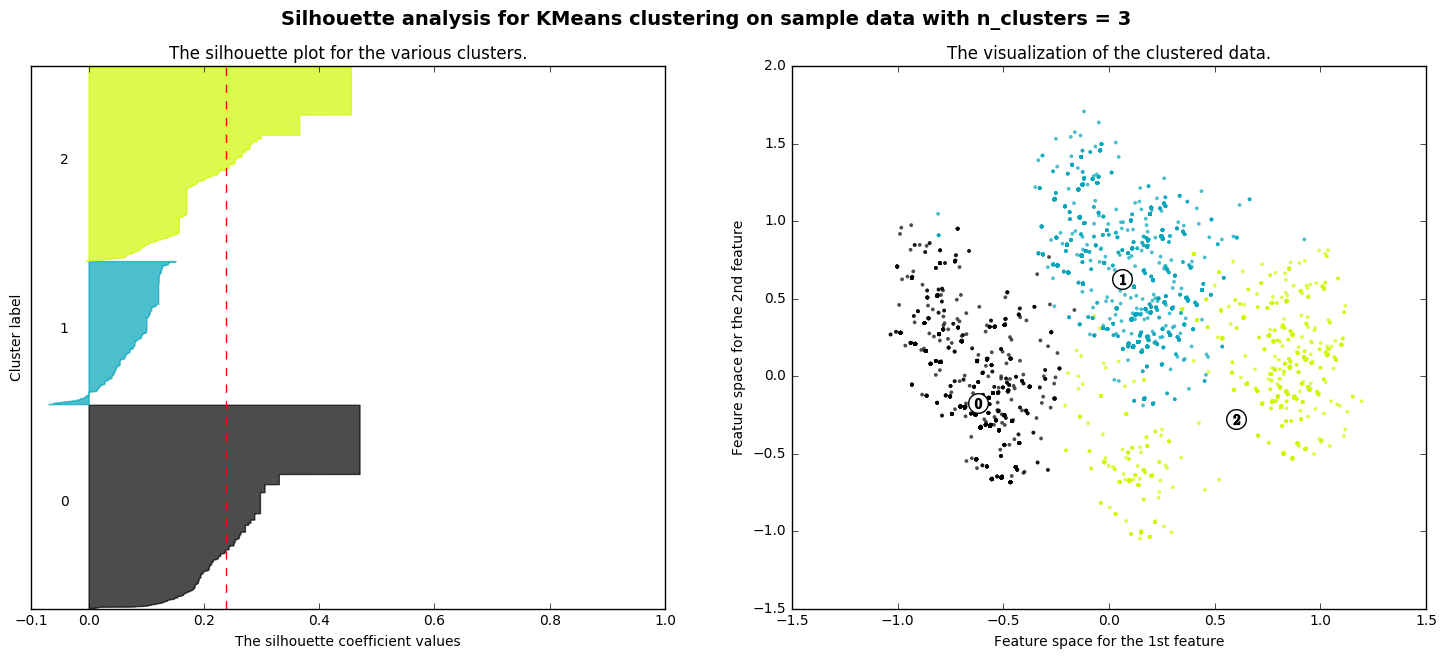

 The Average within sum of square distance is 1.032364


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,rating,title
movieId,,
1204,4.215686,Lawrence of Arabia (1962)
1939,4.636364,"Best Years of Our Lives, The (1946)"
58559,4.235537,"Dark Knight, The (2008)"
104913,4.363636,Rush (2013)
1254,4.300000,"Treasure of the Sierra Madre, The (1948)"
8132,4.454545,Gladiator (1992)
48516,4.202381,"Departed, The (2006)"
1927,4.285714,All Quiet on the Western Front (1930)
926,4.434211,All About Eve (1950)


In [443]:
recommend(titles,moviesdf1,ratingsdf,30,10,1) #kmeans



Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 79, cost: 16003.0
Run 1, iteration: 2/100, moves: 0, cost: 16003.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 418, cost: 19686.0
Run 2, iteration: 2/100, moves: 0, cost: 19686.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 467, cost: 18579.0
Run 3, iteration: 2/100, moves: 0, cost: 18579.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2327, cost: 16003.0
Run 4, iteration: 2/100, moves: 0, cost: 16003.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 20122.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2051, cost: 13609

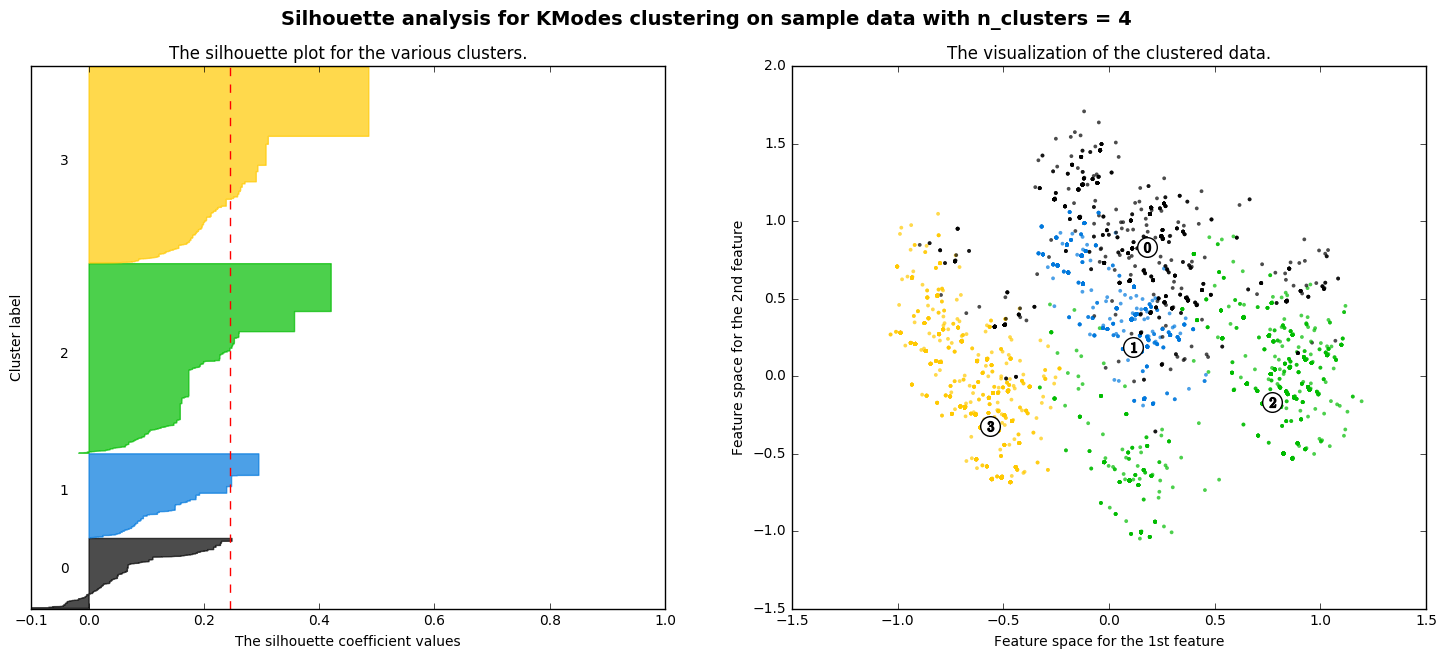

 The Average within sum of square distance is 1.012501


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,rating,title
movieId,,
1178,4.366667,Paths of Glory (1957)
1931,4.250000,Mutiny on the Bounty (1935)
1203,4.304054,12 Angry Men (1957)
2132,4.195652,Who's Afraid of Virginia Woolf? (1966)
105504,4.200000,Captain Phillips (2013)
3469,4.541667,Inherit the Wind (1960)
104913,4.363636,Rush (2013)
3730,4.304348,"Conversation, The (1974)"
2186,4.260870,Strangers on a Train (1951)


In [444]:
recommend(titles,moviesdf1,ratingsdf,30,10,0) #kmodes
